# German_Traffic_Sign_Recognition
![image.png](https://github.com/vivekpatel99/German_Traffic_Sign_Recognition/blob/main/results/result.png)
## About Dataset
### Context
The [German Traffic Sign Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?datasetId=82373)
 is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

**Acknowledgements** \
INI Benchmark Website


## Imports

In [1]:
import logging
import os

# ignore all the warning and debug information from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from libs.nn.conv.lenet import LeNet
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD
from libs.preprocessing import ImageToArrayPreprocessor
from libs.preprocessing import SimplePreprocessor
from libs.datasets import SimpleDatasetLoader

import matplotlib.pyplot as plt
from libs.utils.myplot import plot_confusion_matrix
import matplotlib.image as img
import numpy as np
from imutils import paths
from pathlib import Path
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Prepare Dataset for training

In [3]:
# Look into the data directory
images_dir = './gtsrb-german-traffic-sign'


dataset_dir = f'{images_dir}/Train'
dataset_imgs = list(paths.list_images(dataset_dir))

In [4]:
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 32
RANDOM_STATE=42

In [5]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

class_len = len(classes.keys())

In [6]:
# initialize the image preprocessor
sp = SimplePreprocessor(IMG_WIDTH, IMG_HEIGHT)
iap = ImageToArrayPreprocessor()

# load the dataset from disk 
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])

X, y = sdl.load(dataset_imgs, verbose=500)
X.shape, y.shape

[INFO] processed 500/39209
[INFO] processed 1000/39209
[INFO] processed 1500/39209
[INFO] processed 2000/39209
[INFO] processed 2500/39209
[INFO] processed 3000/39209
[INFO] processed 3500/39209
[INFO] processed 4000/39209
[INFO] processed 4500/39209
[INFO] processed 5000/39209
[INFO] processed 5500/39209
[INFO] processed 6000/39209
[INFO] processed 6500/39209
[INFO] processed 7000/39209
[INFO] processed 7500/39209
[INFO] processed 8000/39209
[INFO] processed 8500/39209
[INFO] processed 9000/39209
[INFO] processed 9500/39209
[INFO] processed 10000/39209
[INFO] processed 10500/39209
[INFO] processed 11000/39209
[INFO] processed 11500/39209
[INFO] processed 12000/39209
[INFO] processed 12500/39209
[INFO] processed 13000/39209
[INFO] processed 13500/39209
[INFO] processed 14000/39209
[INFO] processed 14500/39209
[INFO] processed 15000/39209
[INFO] processed 15500/39209
[INFO] processed 16000/39209
[INFO] processed 16500/39209
[INFO] processed 17000/39209
[INFO] processed 17500/39209
[INFO

((39209, 32, 32, 3), (39209,))

Normalization

In [7]:
X= X.astype("float") / 255.0
np.min(X), np.max(X)

(0.0, 1.0)

Split the dataset into train, and validation

In [8]:
# Separate 20% validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    shuffle=True, 
                                                    stratify=y,
                                                    random_state=RANDOM_STATE 
                                                    )
    
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape          

((31367, 32, 32, 3), (31367,), (7842, 32, 32, 3), (7842,))

In [9]:
len(np.unique(y))

43

In [10]:
y

array(['6', '6', '6', ..., '29', '29', '29'], dtype='<U2')

In [11]:
y_train = keras.utils.to_categorical(y_train, class_len)
y_valid = keras.utils.to_categorical(y_valid, class_len)

print(y_train.shape)
print(y_valid.shape)

(31367, 43)
(7842, 43)


In [12]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Prepare CNN Model

Setting up the callbacks

In [13]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
                                                     
SAVED_MODEL_PATH = 'model/ge_traffic_sign_recognition.h5'
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(SAVED_MODEL_PATH, 
                                                      monitor="val_loss", 
                                                      mode="min",
                                                      save_best_only=True, 
                                                      verbose=1)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "ge_traffic_sign_recog" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [14]:
model = LeNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth= 3, classes=len(classes.keys()))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 20)        1520      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 500)               1

In [15]:
model = LeNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth= 3, classes=len(classes.keys()))
EPOCHS = 40
optimizer = SGD(learning_rate=0.01, weight_decay=0.01/EPOCHS, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [17]:
history = model.fit(X_train,y_train,
                        validation_data=(X_valid, y_valid),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks)

Epoch 1/40
973/981 [============================>.] - ETA: 0s - loss: 1.0224 - accuracy: 0.7136
Epoch 1: val_loss improved from inf to 0.21962, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 4s 3ms/step - loss: 1.0161 - accuracy: 0.7154 - val_loss: 0.2196 - val_accuracy: 0.9411
Epoch 2/40
974/981 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9731
Epoch 2: val_loss improved from 0.21962 to 0.09791, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 2s 2ms/step - loss: 0.1026 - accuracy: 0.9732 - val_loss: 0.0979 - val_accuracy: 0.9759
Epoch 3/40
967/981 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9896
Epoch 3: val_loss improved from 0.09791 to 0.09267, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 2s 2ms/step - loss: 0.0387 - accuracy: 0.9896 - val_loss: 0.0927 - val_accuracy: 0.9754
Epoch 4/

## Evaluate the Model

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

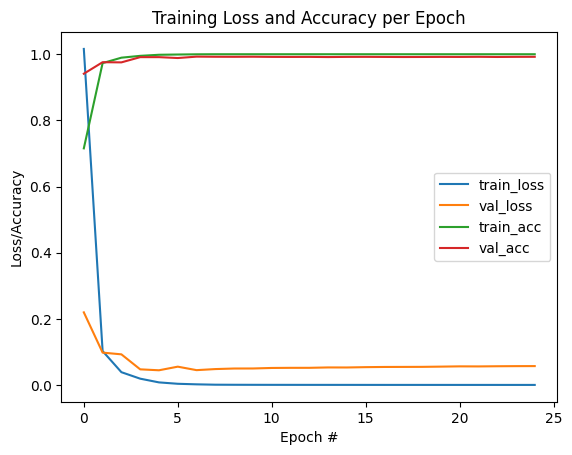

In [19]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy per Epoch")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [20]:
loss, accuracy = model.evaluate(X_valid, y_valid)
loss, accuracy

246/246 [==============================] - 0s 1ms/step - loss: 0.0445 - accuracy: 0.9912


(0.044494159519672394, 0.9912012219429016)

In [21]:
predicted = model.predict(X_valid)
for pred in predicted[:3]:
    print(pred)

246/246 [==============================] - 0s 752us/step
[1.6907324e-10 6.5978818e-15 4.9725789e-11 2.5314854e-14 1.4073210e-18
 5.1161810e-06 4.8506962e-07 7.0085620e-13 2.3203360e-12 6.5777807e-14
 4.7616427e-10 1.4949734e-06 3.8639647e-07 1.4560656e-14 1.9115599e-12
 8.3434648e-11 6.9867267e-13 1.4206050e-12 1.2151078e-12 9.9012520e-11
 2.3267283e-05 6.7969786e-08 6.0572354e-08 4.0756701e-04 1.3804807e-06
 5.1602678e-06 1.8388027e-08 8.2549543e-13 1.6003558e-07 9.9954176e-01
 8.0808632e-06 5.0715862e-06 2.8725746e-09 7.7555734e-15 3.2521458e-11
 2.6489075e-11 3.8654296e-08 3.2973214e-12 9.5528056e-12 9.1870574e-15
 1.2156339e-12 3.2492398e-10 5.4680115e-11]
[6.26481853e-12 1.05931245e-14 1.73056296e-12 1.46338825e-16
 6.14707452e-10 5.34792592e-11 8.48333689e-19 1.42060549e-06
 9.99998569e-01 3.31419926e-11 1.67799482e-15 8.14085483e-16
 4.13075742e-20 2.14278889e-19 1.77578086e-15 6.49815202e-11
 3.43289443e-13 1.38873003e-13 4.13656851e-16 4.27052969e-17
 3.38090701e-11 1.09211907

In [22]:
predicted = np.argmax(predicted, axis=1)
predicted[:5]

array([29,  8, 17,  2, 37])

In [23]:
y_valid = np.argmax(y_valid, axis=1)
y_valid[:5]

array([29,  8, 17,  2, 37])

In [24]:
print(classification_report(y_valid, predicted,
                            target_names=classes.values()))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.98      0.95      0.96        42
         Speed limit (30km/h)       0.99      0.99      0.99       444
         Speed limit (50km/h)       0.99      1.00      0.99       450
         Speed limit (60km/h)       0.98      0.98      0.98       282
         Speed limit (70km/h)       0.99      0.99      0.99       396
         Speed limit (80km/h)       0.98      0.98      0.98       372
  End of speed limit (80km/h)       0.99      1.00      0.99        84
        Speed limit (100km/h)       1.00      0.98      0.99       288
        Speed limit (120km/h)       0.99      1.00      0.99       282
                   No passing       1.00      0.99      0.99       294
 No passing veh over 3.5 tons       0.99      1.00      1.00       402
 Right-of-way at intersection       1.00      0.99      0.99       264
                Priority road       1.00      1.00      1.00       420
     